In [1]:
import json
import csv
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import itertools
import string
from nltk.corpus import stopwords
from sklearn.utils import resample
import gensim
from sklearn import preprocessing
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from trtokenizer.tr_tokenizer import SentenceTokenizer, WordTokenizer
word_tokenizer_object = WordTokenizer()

import warnings
warnings.filterwarnings('ignore')

In [2]:
def clean_text(text):
    
    text = str(text).lower()   
    text = text.translate(str.maketrans('', '', string.punctuation)) # !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    words = word_tokenizer_object.tokenize(text)
    stopWords = set(stopwords.words('turkish'))
    new_text = ' '.join(word for word in words if word not in stopWords)

    return new_text

In [3]:
test = pd.read_csv('test_10_topic.csv', sep='\t')
df_1000 = pd.read_csv('df_1000.csv', sep='\t')
df_hel = pd.read_csv('df_1000_helsinki.csv', sep='\t')
df_det = pd.read_csv('df_1000_detailed.csv', sep='\t')
df_2000 = pd.concat([df_1000, df_1000])

In [4]:
df_1000['title'][908]

"İtalya'da yeniden erken seçim gündemde"

In [5]:
df_hel['title'][1908]

"İtalya'da erken seçimlerin yeniden seçilmesi gündemde"

In [6]:
df_det['title'][1908]

'["İtalya\'da hükümetin yarım aylık olacağını, ancak bugünkü seçimlerde yeniden kabul edilen \'evet\' iadesi bekleniyor."]'

In [7]:
class_names = np.unique(df_1000['topic'])
class_names

array(['Dünya', 'Ekonomi', 'Eğitim', 'Kültür_Sanat', 'Magazin',
       'Otomobil', 'Sağlık', 'Siyaset', 'Spor', 'Teknoloji'], dtype=object)

In [8]:
df_hel[df_hel['title'].isnull()].index.tolist()

[1264, 1314, 1341, 1359]

In [9]:
df_hel = df_hel.drop(index=[264, 314, 341, 359, 1264, 1314, 1341, 1359])
df_det = df_det.drop(index=[264, 314, 341, 359, 1264, 1314, 1341, 1359])
df_2000 = df_2000.drop(index=[264, 314, 341, 359])
df_1000 = df_1000.drop(index=[264, 314, 341, 359])

In [8]:
#df_1000 = df_1000.dropna()
#df_2000 = df_2000.dropna()
#df_hel = df_hel.dropna()
#df_det = df_det.dropna()

In [10]:
len(df_det)

1992

<AxesSubplot:xlabel='topic', ylabel='count'>

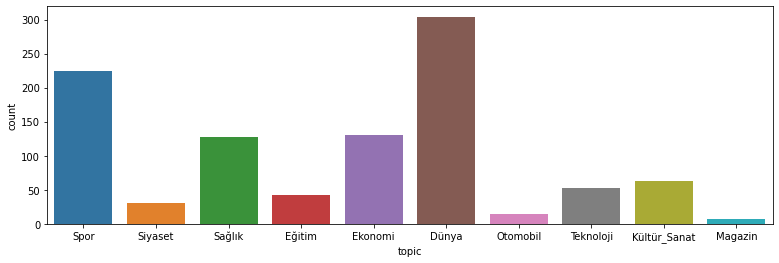

In [11]:
plt.figure(figsize=(13, 4))
sns.countplot(df_1000['topic'])

In [12]:
test.title = [clean_text(text) for text in test.title]
test.head()

,Unnamed: 0,abstract,title,topic
0,276806,sakarya’nın serdivan ilçesinde serdivanspor ka...,sahada başlayan kavga tribüne sıçradı 8 kırmız...,Spor
1,276807,avustralya başbakanı scott morrison merkezde k...,nauru gözaltı merkezinde sığınmacı çocuk kalma...,Dünya
2,276808,seat soğuk kış günlerinde otomobil camlarındak...,seat’tan kış ayları 4 öneri,Otomobil
3,276811,i lerleyen yaşla birlikte cildin elastikiyetin...,kış güneşi cildinizi hızla yaşlandırıyor,Sağlık
4,276813,sudan dışişleri bakanı ahmed oac hükümeti sila...,oacde nihai barış anlaşması çarşamba imzalanacak,Dünya


### TF-IDF

In [11]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

for n_fold, (_, val_index) in enumerate(kf.split(df_2000[:len(df_2000)//2])):
    after_1000 = np.asarray([(i + 1000) for i in val_index])
    val_index = np.concatenate((val_index, after_1000))
    train_index = list(set(list(range(0, 2000))) - set(val_index))
    print(val_index, train_index)

[  10   23   25   30   39   44   54   55   59   60   63   66   67   70
   72   76   78   86   88   96  101  107  110  120  136  137  139  158
  168  174  184  198  199  208  209  210  213  215  218  221  235  237
  244  247  254  256  259  260  261  265  275  277  280  281  289  292
  294  296  298  299  307  309  310  312  314  318  319  321  327  328
  332  346  351  355  361  363  365  370  371  377  382  408  411  425
  429  432  436  439  445  451  462  479  486  493  494  499  513  521
  522  526  527  528  529  534  542  543  548  549  554  559  570  578
  583  584  589  590  595  599  601  604  613  617  621  626  635  636
  643  644  649  650  652  656  660  662  668  670  677  678  679  687
  689  692  697  713  714  716  721  737  740  741  749  753  761  764
  767  787  800  802  810  811  816  820  822  823  826  829  837  845
  849  859  865  866  867  879  883  884  892  893  899  901  902  914
  917  924  936  938  941  942  947  948  959  973  974  977  978  985
  986 

In [13]:
def execute_model(model):
    
    scores_f1 = []
    
    pipe = make_pipeline(TfidfVectorizer(), StandardScaler(with_mean=False), model)
    kf = KFold(n_splits=5, random_state=42, shuffle=True)      
    length = len(df)//2

    for n_fold, (_, val_i) in enumerate(kf.split(range(length))):
        
        after_half = np.asarray([(i + length) for i in val_i])
        val_index = np.concatenate((val_i, after_half))
        train_index = list(set(list(range(0, len(df)))) - set(val_index))

        X_train = df.iloc[train_index]['title']
        y_train = df.iloc[train_index]['topic']

        #X_valid = df.iloc[val_index]['title']
        #y_valid = df.iloc[val_index]['topic']
        
        X_valid = test['title']
        y_valid = test['topic']

        m = pipe.fit(X_train, y_train)
        y_pred = m.predict(X_valid)

        f1 = f1_score(y_valid, y_pred, average='macro')        
        scores_f1.append(f1)
        
    print(np.mean(scores_f1), '\t', np.std(scores_f1))
    
    return pipe, np.mean(scores_f1), np.std(scores_f1)

In [14]:
datasets = [df_1000, df_2000, df_hel, df_det]

In [15]:
lsvc_f1s = []
lsvc_stds = []

for dataset in datasets:
    
    df = copy.deepcopy(dataset)
    df.title = [clean_text(text) for text in df.title]
    
    lsvc_pipe, lsvc_f1_mean, lsvc_std = execute_model(LinearSVC())
    lsvc_f1s.append(lsvc_f1_mean)
    lsvc_stds.append(lsvc_std)

lsvc_f1s =  [f"{num:.3f}" for num in lsvc_f1s]
lsvc_stds =  [f"{num:.3f}" for num in lsvc_stds]

0.375308861677649 	 0.005710436339228631
0.37556672552624154 	 0.008424761957904063
0.3759858448100732 	 0.011372433472388987
0.4030679328801409 	 0.0081604324598135


In [16]:
rf_f1s = []
rf_stds = []

for dataset in datasets:
    
    df = copy.deepcopy(dataset)    
    df.title = [clean_text(text) for text in df.title]
    
    rf_pipe, rf_f1_mean, rf_std = execute_model(RandomForestClassifier())
    rf_f1s.append(rf_f1_mean)
    rf_stds.append(rf_std)
    
rf_f1s =  [f"{num:.3f}" for num in rf_f1s]
rf_stds =  [f"{num:.3f}" for num in rf_stds]

0.21541812894857051 	 0.01215149703103004
0.24256316606780146 	 0.007568455666752966
0.2747750060055075 	 0.010181909563199148
0.26073244241426036 	 0.00697752835874629


In [17]:
lr_f1s = []
lr_stds = []

for dataset in datasets:
    
    df = copy.deepcopy(dataset)   
    df.title = [clean_text(text) for text in df.title]
    
    lr_pipe, lr_f1_mean, lr_std = execute_model(LogisticRegression())
    lr_f1s.append(lr_f1_mean)
    lr_stds.append(lr_std)
    
lr_f1s =  [f"{num:.3f}" for num in lr_f1s]
lr_stds =  [f"{num:.3f}" for num in lr_stds]

0.35128940875229536 	 0.0027247058054979756
0.3521431827489547 	 0.008555590839107553
0.3561992614893481 	 0.009878341341819998
0.37384966108073003 	 0.005947998252322688


In [18]:
print("\nF1-Score Table:")
f1_df = {'Dataset': ['ds_1000', 'ds_1000_copy', 'ds_1000_back', 'ds_1000_det'], 
             'Linear_SVC': lsvc_f1s, 
             'Random_forest': rf_f1s, 
             'Logistic_regression': lr_f1s}

f1_df = pd.DataFrame.from_dict(f1_df).set_index('Dataset')
f1_df


F1-Score Tablosu:


,Linear_SVC,Random_forest,Logistic_regression
Dataset,,,
ds_1000,0.375,0.215,0.351
ds_1000_copy,0.376,0.243,0.352
ds_1000_back,0.376,0.275,0.356
ds_1000_det,0.403,0.261,0.374


In [19]:
print("\nStandard Deviation Table:")
std_df = {'Dataset': ['ds_1000', 'ds_1000_copy', 'ds_1000_back', 'ds_1000_det'], 
             'Linear_SVC': lsvc_stds, 
             'Random_forest': rf_stds, 
             'Logistic_regression': lr_stds}

std_df = pd.DataFrame.from_dict(std_df).set_index('Dataset')
std_df


Standart Sapma Tablosu:


,Linear_SVC,Random_forest,Logistic_regression
Dataset,,,
ds_1000,0.006,0.012,0.003
ds_1000_copy,0.008,0.008,0.009
ds_1000_back,0.011,0.010,0.010
ds_1000_det,0.008,0.007,0.006
